Steane code error detection - decoding without noise
===========================================

1. Set up logical zero for Steane code based  on the parity matrix in the book by Nielsen MA, Chuang IL. Quantum Computation and Quantum Information, 10th Anniversary Edition. Cambridge University Press; 2016. p. 474

2. Set up the ancilla and measure the outputs.

3. Introduce a Pauli X error

3. Use ancilla measurements to correct the data using Python code and check that without noise all errors are corrected 

Import the necessary function modules, including the SteaneCodeLogicalQubit class.  The methods of this class are called in this notebook.

In [1]:
from qiskit import(
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer
    )

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.compiler import transpile

from circuits import SteaneCodeLogicalQubit

import matplotlib.pyplot as plt
import numpy as np

from helper_functions import (
    count_valid_output_strings,
    find_individual_ancilla_values,
    find_ancilla_values,
    find_parity,
    string_reverse,
    strings_AND_bitwise,
    string_ancilla_mask,
    correct_qubit
    )

Define constants so the process flow can be controlled from one place:

In [2]:
SINGLE_GATE_SET = ['id', 'ry', 'rx']
TWO_GATE_SET = ['rxx']
BASIS_GATE_SET = SINGLE_GATE_SET + TWO_GATE_SET

DATA_QUBITS = 7
ANCILLA_QUBITS = 3
SHOTS = 10000 #Number of shots to run    

SIMULATOR = Aer.get_backend('qasm_simulator')
SPACE = ' '

We specify the parity check matrix, since this defines the Steane code.  It is validated before the logical qubit is initiated to check that it is orthogonal to the valid codewords.

In [3]:
parity_check_matrix = [[0,0,0,1,1,1,1],
                       [0,1,1,0,0,1,1],
                       [1,0,1,0,1,0,1]]

The allowed codewords for the zero logical from Nielsen and Chuang is stored in a list.  Note, the order of qubits in the list is reversed compared to the normal output of Qiskit.

In [4]:
codewords = [[0,0,0,0,0,0,0],   
             [1,0,1,0,1,0,1],
             [0,1,1,0,0,1,1],
             [1,1,0,0,1,1,0],
             [0,0,0,1,1,1,1],
             [1,0,1,1,0,1,0],
             [0,1,1,1,1,0,0],
             [1,1,0,1,0,0,1]]

In [5]:
#scenarios
runs = {'I':{},
        'X1':{'test_x_qubit': 0},
        'X2':{'test_x_qubit': 1},
        'X3':{'test_x_qubit': 2},
        'X4':{'test_x_qubit': 3},
        'X5':{'test_x_qubit': 4},
        'X6':{'test_x_qubit': 5},
        'X7':{'test_x_qubit': 6}
       }

Post selection error correction
--------------------------------------------

The error detection circuit is added to the encoding circuit and transpiled.  Then, without noise, X error are added and a python software correction routine is run to correct the data bit based on the ancilla reading.  We expect that all the errors are corrected, so after correction the error rate is zero.  The error rate is one if an X errors are applied, and zero otherwise.

In [6]:
#initialise lists for graphs results
values_list = [[] for i in range(ANCILLA_QUBITS * 2)]
labels_list = [str(j) + str(i + 1) for j in ['x', 'z'] for i in range(3)]
cases_list = []
print(f'Run with {SHOTS} shots')
for cases, parameters in runs.items():
    test_x = True
    if 'test_x_qubit' in parameters:
        x_bit = parameters.get('test_x_qubit')
    else:
        test_x = False
    test_z = True
    if 'test_z_qubit' in parameters:
        z_bit = parameters.get('test_z_qubit')
    else:
        test_z = False  
    qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords)
    qubit.set_up_logical_zero()
    qubit.barrier() 
    if test_x:
        qubit.force_X_error(x_bit)   #force X error for testing
    if test_z:
        qubit.force_Z_error(z_bit)   #force Z error for testing
    qubit.barrier()
    qubit.set_up_ancilla()
    qubit.barrier()
    qubit.logical_measure()
    qubit.barrier()

    qt = transpile(qubit, basis_gates = BASIS_GATE_SET)
    result = execute(qt, SIMULATOR, shots = SHOTS).result()
    counts = result.get_counts(qt)

    print()
    print(f'For run {cases}')
    cases_list.append(cases)
        
    count_valid, count_invalid = count_valid_output_strings(counts, codewords, 2)
    error_rate = count_invalid / SHOTS
    print(f'The error rate with no error correction is {error_rate:.4f}')
    
    new_counts = {}
    for key, values in counts.items():
        # X ancilla
        key0 = key.split()[0]
        # Z ancilla
        key1 = key.split()[1]
        #data qubits
        key2 = key.split()[2]
        new_key2 = correct_qubit(key2, key0, DATA_QUBITS)
        new_key = key0 + SPACE + key1 + SPACE + new_key2        
        if new_counts.get(new_key) == None: 
            new_counts.update({new_key: values})
        else:
            new_counts[new_key] = new_counts[new_key] + values

    count_valid, count_invalid = count_valid_output_strings(new_counts, codewords, 2)
    error_rate = count_invalid / SHOTS
    print(f'The error rate after correction is {error_rate:.4f}')
     
    for i in ['x', 'z']:
        if i == 'x':
            index = 0        
        elif i == 'z':
            index = 1
        else:
            raise Exception ('Unexpected ancilla value')           
        ancilla_values = find_ancilla_values(counts, ANCILLA_QUBITS, index) 
        print(f'  The different ancilla values for {i} are {ancilla_values}')
        individual_ancilla_values = find_individual_ancilla_values(ancilla_values, 0, ANCILLA_QUBITS, i)       
        print(f'  By ancilla the values for {i} are {individual_ancilla_values}')          
        index = 0
        for labels in labels_list:
            if labels in individual_ancilla_values.keys():
                values_list[index].append(individual_ancilla_values.get(labels) / SHOTS)
            index = index + 1

Run with 10000 shots

For run I
The error rate with no error correction is 0.0000
The error rate after correction is 0.0000
  The different ancilla values for x are {'000': 10000, '001': 0, '010': 0, '011': 0, '100': 0, '101': 0, '110': 0, '111': 0}
  By ancilla the values for x are {'x1': 0, 'x2': 0, 'x3': 0}
  The different ancilla values for z are {'000': 10000, '001': 0, '010': 0, '011': 0, '100': 0, '101': 0, '110': 0, '111': 0}
  By ancilla the values for z are {'z1': 0, 'z2': 0, 'z3': 0}

For run X1
The error rate with no error correction is 1.0000
The error rate after correction is 0.0000
  The different ancilla values for x are {'000': 0, '001': 0, '010': 0, '011': 0, '100': 10000, '101': 0, '110': 0, '111': 0}
  By ancilla the values for x are {'x1': 0, 'x2': 0, 'x3': 10000}
  The different ancilla values for z are {'000': 10000, '001': 0, '010': 0, '011': 0, '100': 0, '101': 0, '110': 0, '111': 0}
  By ancilla the values for z are {'z1': 0, 'z2': 0, 'z3': 0}

For run X2
The 

Print out graph

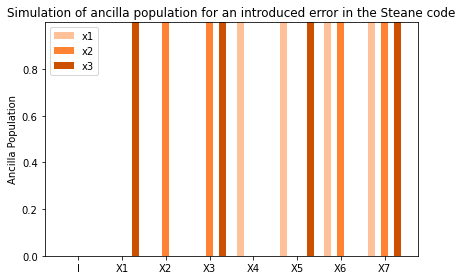

In [7]:
#graph constants
YMIN = 0
YMAX = 1.0
YTICK = 0.2
WIDTH = 0.20
GAP = .8

x = np.arange(len(cases_list))  # the label locations

fig, ax = plt.subplots()
plt.bar(x - WIDTH *  3 / 2 ,values_list[0], color = '#ffc199', width = WIDTH * GAP, label = labels_list[0])
plt.bar(x , values_list[1], color = '#ff8333', width = WIDTH * GAP, label = labels_list[1])
plt.bar(x + WIDTH * 3 / 2 ,values_list[2], color = '#cc5000', width = WIDTH * GAP, label = labels_list[2])

ax.set_ylabel('Ancilla Population')
ax.set_title('Simulation of ancilla population for an introduced error in the Steane code')
ax.set_xticks(x)
ax.set_xticklabels(cases_list)
ax.legend()

plt.ylim(YMIN, YMAX)
plt.yticks(np.arange(YMIN, YMAX, YTICK))

fig.tight_layout()

fname = "Steane_code_ancilla_graph.png"
plt.savefig(fname)

Draw circuit

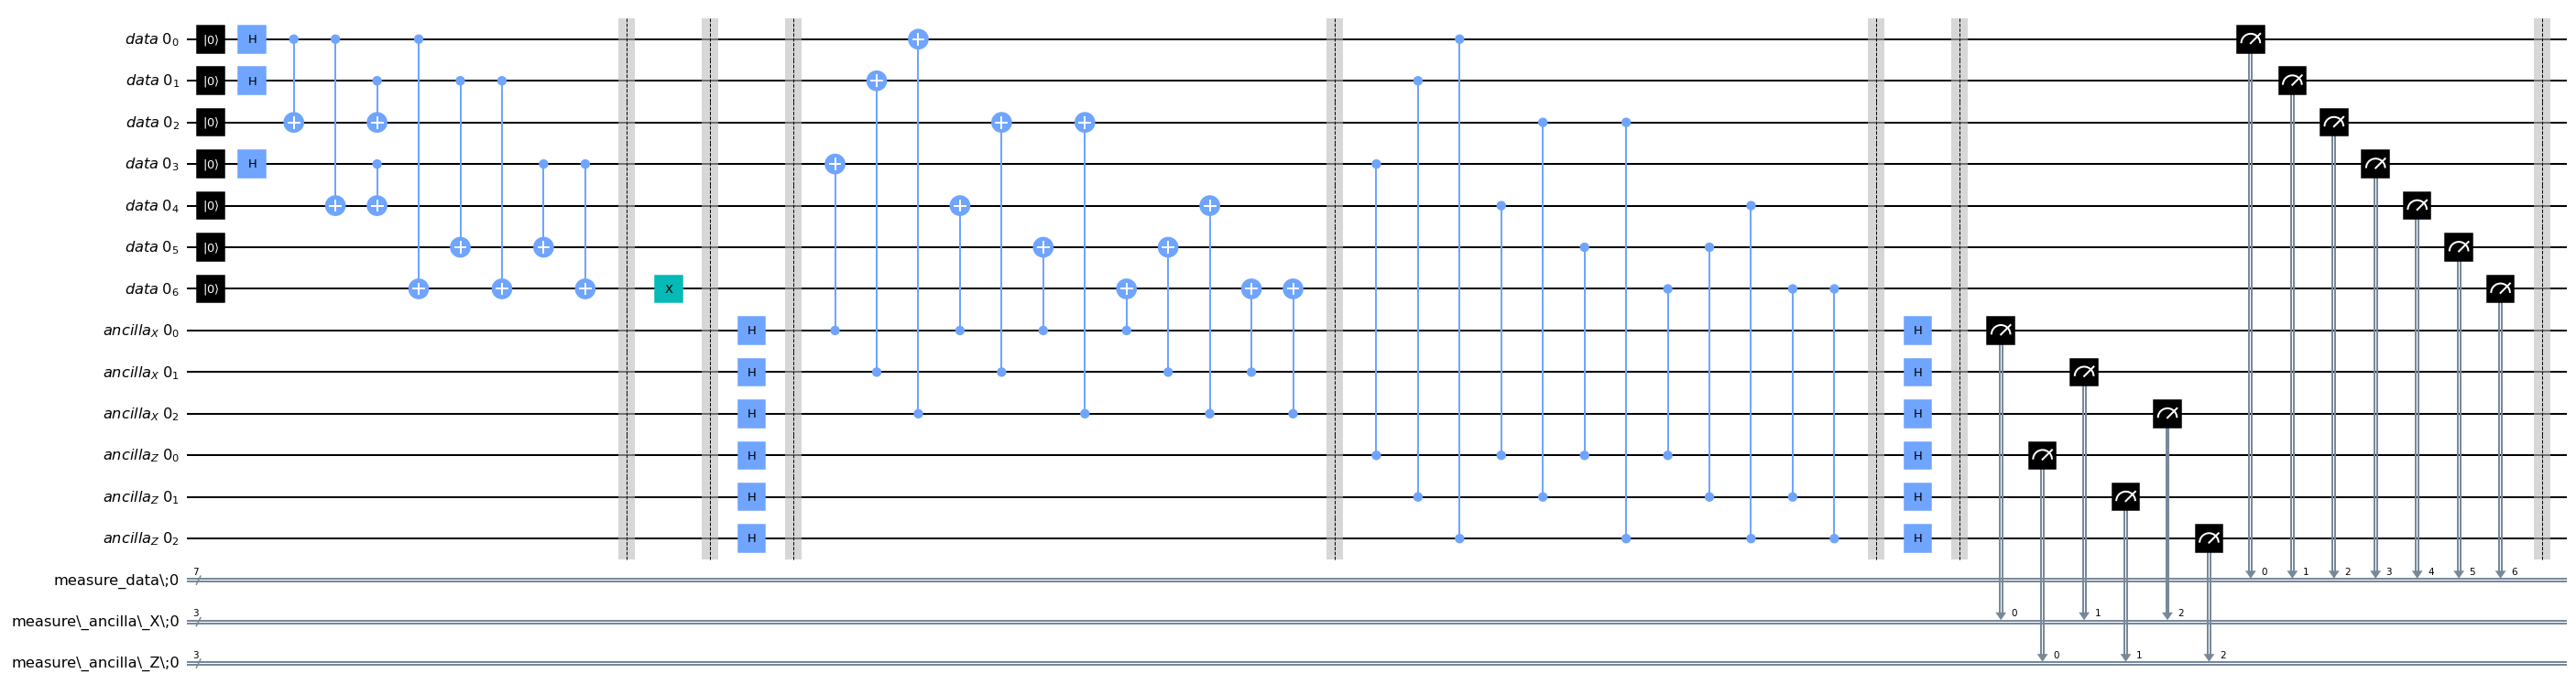

In [8]:
qubit.draw(output = 'mpl', filename = 'Steane_code_error_detection_circuit.jpg', fold = 60)

Draw transpiled circuit

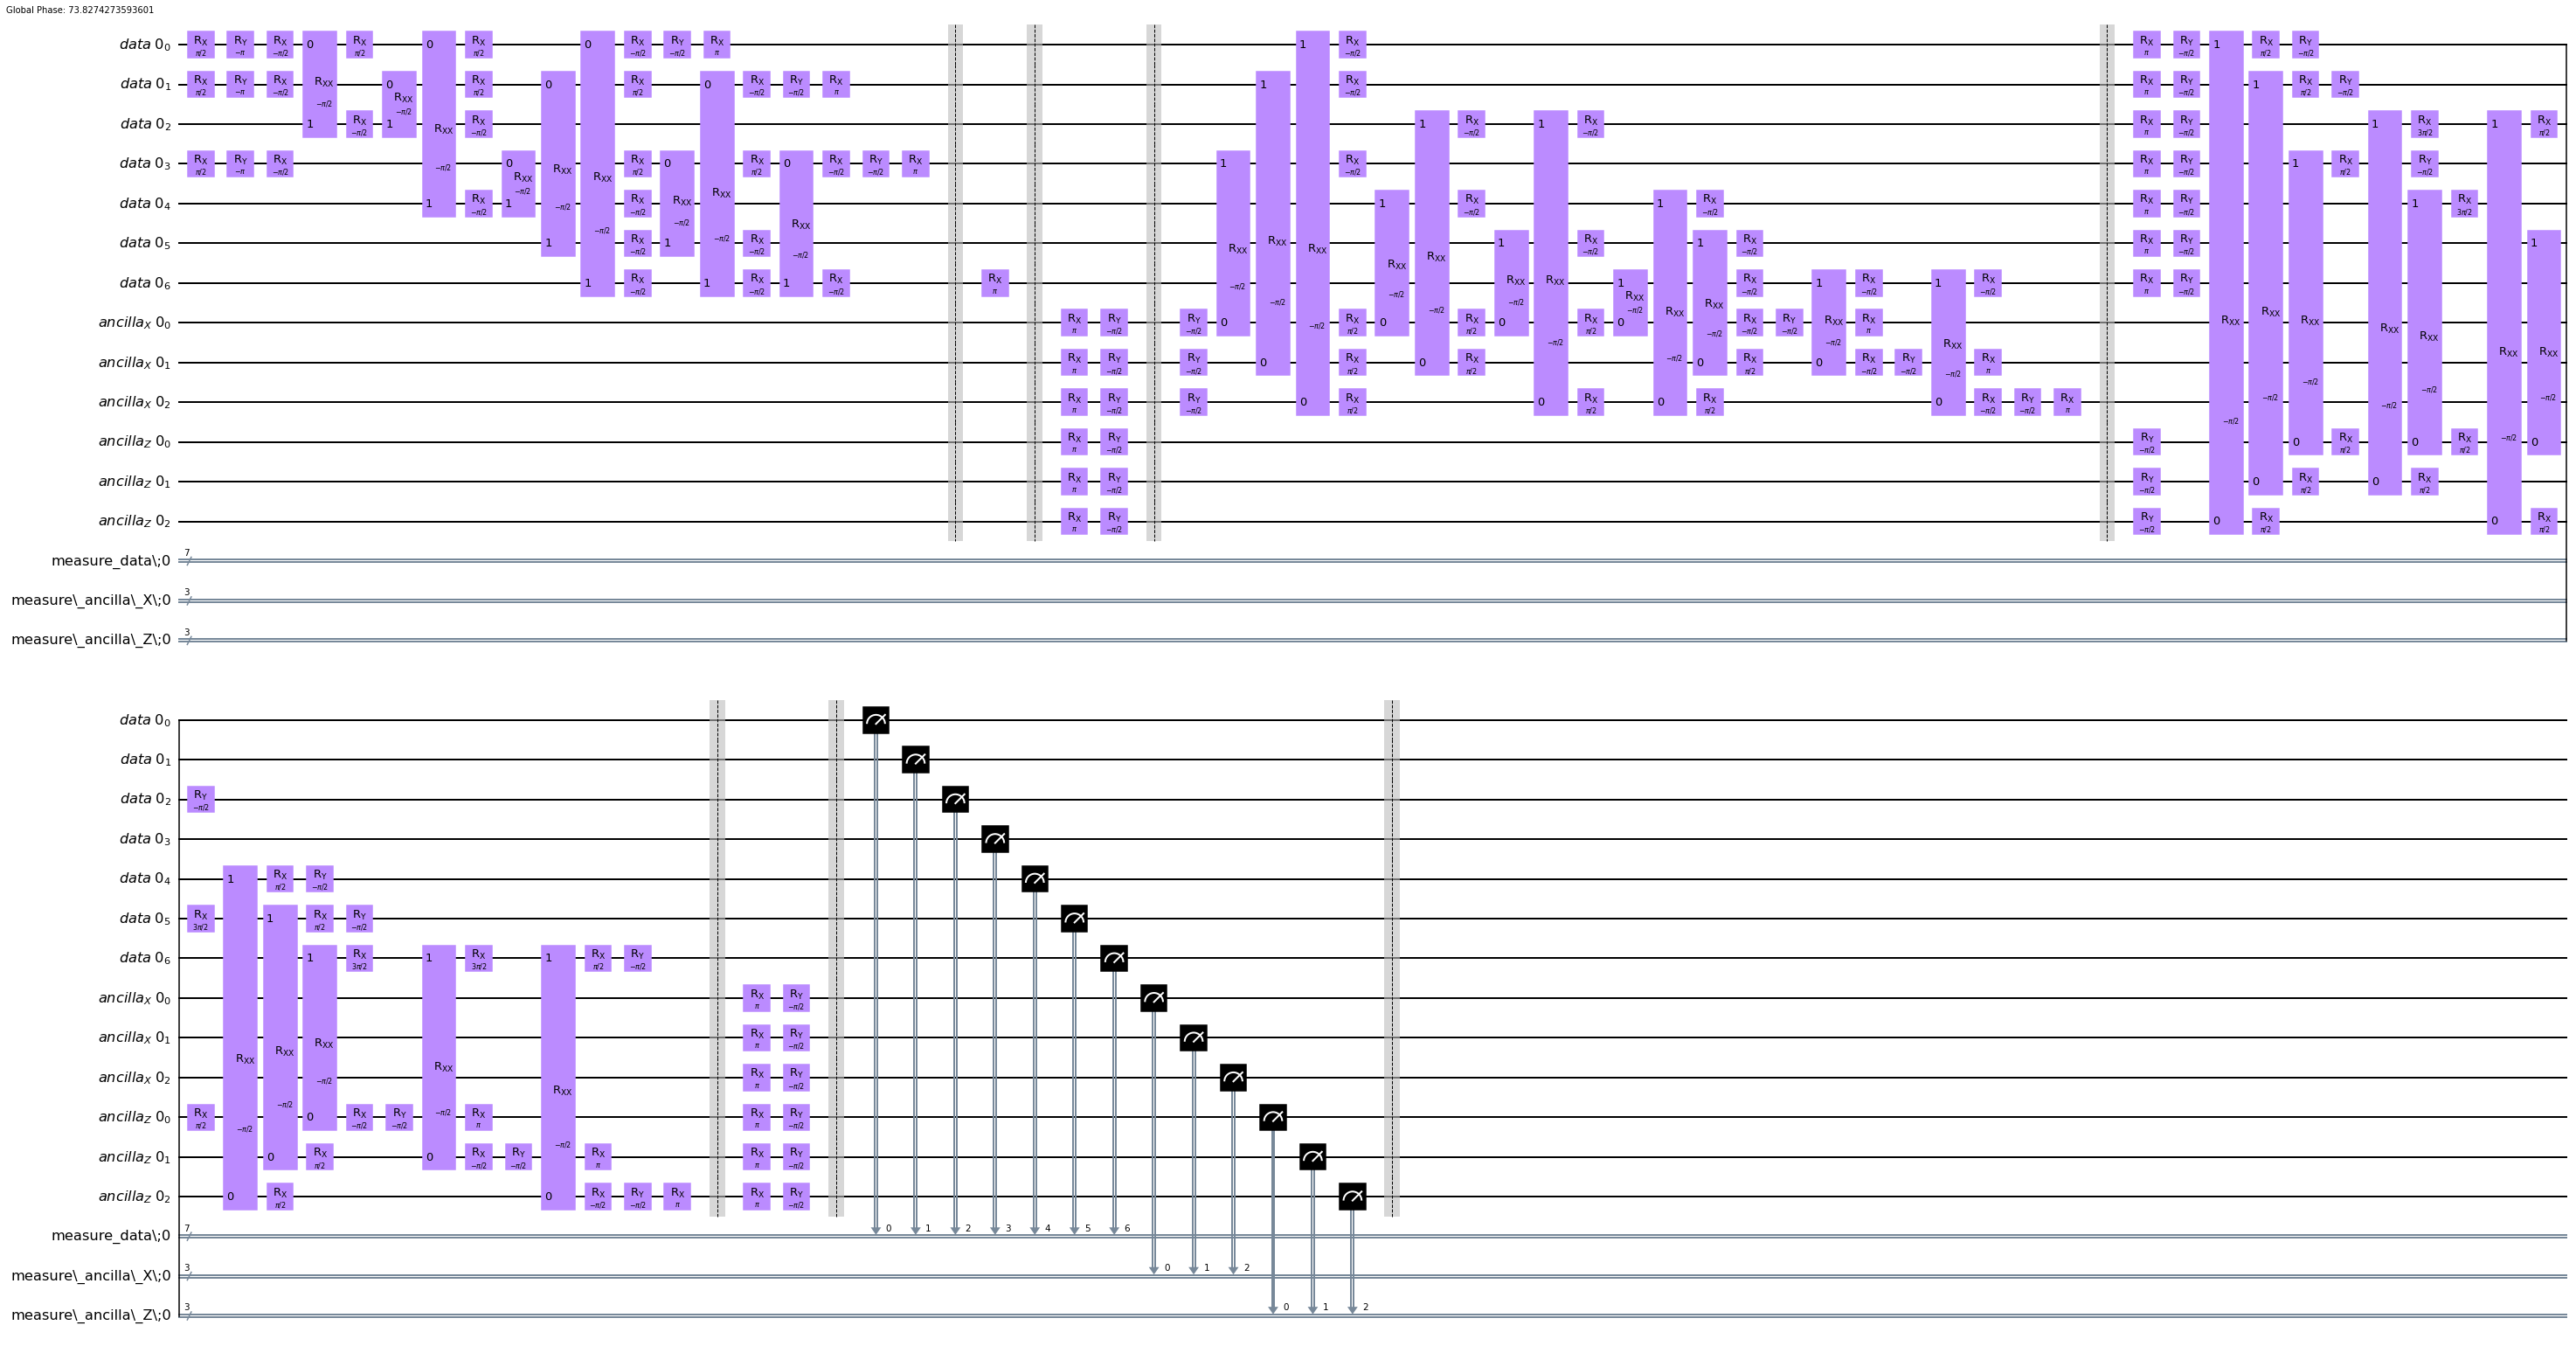

In [9]:
qt.draw(output = 'mpl', filename = 'Steane_code_error_detection_circuit_transpiled.jpg', fold = 60)